### Important librairies

In [1]:
#Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import Image
from lxml import objectify
import math
import time
from pytrends.request import TrendReq
from wordcloud import WordCloud

#Import data from wikidata.org
from wikidata2df import wikidata2df

#Convert country name to ISO-3
import country_converter as coco

#World map plot librairies
import plotly.offline as po
import plotly.graph_objs as pg
import plotly.express as px
import plotly.graph_objs as go

# Analysis of the lexical fields
from empath import Empath 

#Warnings
import warnings

data_folder = './data/'

## 1) Data handling

### Import and handling of the dataset


#### Movie metadata & characters

In [2]:
### Movie metadata import
df_movie = pd.read_table(data_folder +'movie.metadata.tsv',header=None)
df_movie.columns=['Wikipedia_movie_ID' , 'Freebase_movie_ID', 'Movie_name' , 'Movie_date' , 'Movie_revenue' , 'Movie_runtime' , 'Movie_languages' , 'Movie_countries' , 'Movie_genres']
df_movie['Movie_countries'] = df_movie['Movie_countries'].apply( lambda x: list(eval(x).values())) #display countries as a list of country names
df_movie['Movie_genres'] = df_movie['Movie_genres'].apply( lambda x: list(eval(x).values()) ) #display genres as a list of genre name
df_movie

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}",[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}",[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}",[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


In [3]:
### Character metadata import
df_character = pd.read_table(data_folder +'character.metadata.tsv',header=None)
df_character.columns=['Wikipedia_movie_ID' , 'Freebase_movie_ID' , 'Movie_date' , 'Character_name' , 'Actor_date_of_birth' , 'Actor_gender' , 'Actor_height' , 'Actor_ethnicity' , 'Actor_name' , 'Actor_age_at_movie_release' , 'Freebase_character_actor_ID' , 'Freebase_character_ID' , 'Freebase_actor_ID'  ]

#Correct when actor age is negative or too high to be real (higher than 130)
df_character['Actor_age_at_movie_release']=df_character['Actor_age_at_movie_release'].apply(lambda x: -x if x<0 else x)
df_character['Actor_age_at_movie_release']=df_character['Actor_age_at_movie_release'].apply(lambda x: float("nan") if x>130 else x)


In [4]:
#create a SPARQL wikidata query to retrieve the wrong actor gender
gender = '''
SELECT ?Freebase_actor_ID ?genderLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?film wdt:P31 wd:Q5;
    wdt:P106 wd:Q33999;
    wdt:P21 ?gender;
    wdt:P646 ?Freebase_actor_ID.
}
'''
gend = wikidata2df(gender)
gend.loc[gend.genderLabel == 'male', 'genderLabel'] = 'M'
gend.loc[gend.genderLabel == 'female', 'genderLabel'] = 'F'
gend

,Freebase_actor_ID,genderLabel
0,/m/01vrncs,M
1,/m/0jwtj,F
2,/m/01n4f8,M
3,/m/0252s_,M
4,/m/01437b,F
...,...,...
104878,/m/0ndd54k,M
104879,/m/0gc65pw,F
104880,/m/0_xpcvl,M
104881,/m/0qzqk99,M


In [5]:
#merge the gender index with the actor dataset
characters = df_character.merge(gend, on = 'Freebase_actor_ID', how='left')
characters = characters.loc[characters.Freebase_character_actor_ID.drop_duplicates().index]
characters['Actor_gender'] = characters.genderLabel.fillna(characters.Actor_gender)
characters = characters.drop(columns=['genderLabel'])
characters

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450804,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450805,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450806,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450807,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [6]:
#create a SPARQL wikidata query to retrieve the actor ethnicity
ethnicity1 = '''
SELECT ?ethnicLabel ?Freebase WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?ethnic wdt:P31 wd:Q28790362;
    wdt:P646 ?Freebase.
}
'''
ethnicity2 = '''
SELECT ?ethnicLabel ?Freebase WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?ethnic wdt:P31 wd:Q41710;
    wdt:P646 ?Freebase.
}
'''
ethnic = pd.concat([wikidata2df(ethnicity1),wikidata2df(ethnicity2)])

In [7]:
charactersfinal = characters.merge(ethnic, left_on = 'Actor_ethnicity', right_on = 'Freebase', how = 'left').drop(columns = ['Freebase'])
charactersfinal = charactersfinal.loc[charactersfinal.Freebase_character_actor_ID.drop_duplicates().index]
charactersfinal = charactersfinal.reset_index()
charactersfinal

,index,Wikipedia_movie_ID,Freebase_movie_ID,Movie_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_ID,Freebase_character_ID,Freebase_actor_ID,ethnicLabel
0,0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,451466,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN
450665,451467,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN
450666,451468,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,English people
450667,451469,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN


## 2) Data exploration

It is important to notice that for each movies, several countries name are specified. We consider each of these countries as country of origin of the movie. Thus, the total number of occurences is much larger than the total number of movies. So we decided to count a movie for each country where it took place.

For instance, here the movie "Knuckle" has been shot in Ireland and United Kingdom. So it will be coutned as one movie for Ireland and one for United Kingdom.

In [8]:
print(df_movie.iloc[81737]['Movie_name'])
print(df_movie.iloc[81737]['Movie_countries'])

Knuckle
['Ireland', 'United Kingdom']


### 2.1) Analysis movie done by each country

In [9]:
### First step is to create a new dataset with all countries and numbers of movies done by country.
# !!!! Some movies may have been shoot in different countries !!!
#Here when a movie appears in two countries, it is count for one movie in each country

Movie_by_country = df_movie['Movie_countries'].explode() #Separate countries when a movie has several of them
Movie_by_country = Movie_by_country.str.split(',') #Split on comma
Movie_by_country = pd.DataFrame(Movie_by_country) 
Movie_by_country = pd.DataFrame(Movie_by_country.Movie_countries.value_counts().reset_index()).rename(columns={"index": "Country" , "Movie_countries": "Number_of_movie"}) #Count the number of occurence of a country
Movie_by_country['Percent'] = (Movie_by_country['Number_of_movie']/Movie_by_country['Number_of_movie'].sum())*100
Movie_by_country['Country'] = Movie_by_country['Country'].map(lambda x: str(x).replace("^\[.|.\]$",""))
Movie_by_country #Final dataset for country

,Country,Number_of_movie,Percent
0,['United States of America'],34408,39.806106
1,['India'],8411,9.730561
2,['United Kingdom'],7868,9.102373
3,['France'],4395,5.084510
4,['Italy'],3163,3.659228
...,...,...,...
142,['Republic of China'],1,0.001157
143,['Macau'],1,0.001157
144,['Palestinian Territories'],1,0.001157
145,['German Language'],1,0.001157


In [10]:
### Plot numbers of movie on the world

#Initialisation of country converter to iso-3
cc = coco.CountryConverter()

#Convert country name to ISO3
some_countries = pd.Series(Movie_by_country['Country'])
iso3_codes = cc.pandas_convert(some_countries, to='ISO3') #convert the name of the country to ISO3  
Movie_by_country.insert(1,"code",iso3_codes)#add a code column corresponding to ISO3 abreviation of the country

#Plot 
data = dict(type='choropleth', 
           locations = Movie_by_country['code'], 
           z = Movie_by_country['Percent'], 
           text = Movie_by_country['Country'])

layout = dict(title = 'Percentage of movies in the dataset - robinson projection',
              geo = dict( projection = {'type':'robinson'},
                         showlakes = False, 
                         lakecolor = 'rgb(0,191,255)'))
x = pg.Figure(data = [data], 
              layout = layout)
po.iplot(x)  #interactive image


#x.write_image("img/world_map.png", engine="kaleido")
#Image("img/world_map.png")

['Soviet Union'] not found in regex
['German Democratic Republic'] not found in regex
['Yugoslavia'] not found in regex
['England'] not found in regex
['Weimar Republic'] not found in regex
['Scotland'] not found in regex
['Socialist Federal Republic of Yugoslavia'] not found in regex
['Serbia and Montenegro'] not found in regex
['Federal Republic of Yugoslavia'] not found in regex
['Wales'] not found in regex
['Northern Ireland'] not found in regex
['Congo'] not found in regex
['Soviet occupation zone'] not found in regex
['Malayalam Language'] not found in regex
['Crime'] not found in regex
['German Language'] not found in regex
['Ukranian SSR'] not found in regex


### 2.2) Analyse actors and actresses of each countries

In [11]:
#### Add the number of acting done in each country ###
# !!!! Some movies may have been shoot in different countries !!!

#Initialisation to have movie by country.
df_act_by_country = df_movie['Movie_countries'].explode()
df_act_by_country = df_act_by_country.str.split(',') 
df_act_by_country = pd.DataFrame(df_act_by_country)
df_act_by_country = pd.DataFrame(df_act_by_country.Movie_countries.value_counts().reset_index()).rename(columns={"index": "Country" , "Movie_countries": "Number_of_movie"})

#Initialisation to count the number of actors and actresses by country
actress_count=[]
actor_count=[]

#Loop on country to count
for country in df_act_by_country['Country']:
  
  inter_country = df_movie.loc[df_movie['Movie_countries'].explode().isin(country)[df_movie['Movie_countries'].explode().isin(country)].index] #Create a dataset of movie for only one country
  inter_character_country = charactersfinal.merge(inter_country['Freebase_movie_ID'], on='Freebase_movie_ID') #Create a dataset of character for only one country
  
  actress_count.append(inter_character_country[inter_character_country['Actor_gender'] == 'F']['Actor_gender'].count()) #Count actor
  actor_count.append(inter_character_country[inter_character_country['Actor_gender'] == 'M']['Actor_gender'].count()) #Count actress

Movie_by_country['Number_acting_male']= actor_count
Movie_by_country['Number_acting_female']= actress_count

In [12]:
Movie_by_country['Total_Act'] = Movie_by_country['Number_acting_male']+Movie_by_country['Number_acting_female']
Movie_by_country #Final dataframe for actors and actresses by country

,Country,code,Number_of_movie,Percent,Number_acting_male,Number_acting_female,Total_Act
0,['United States of America'],USA,34408,39.806106,152683,73382,226065
1,['India'],IND,8411,9.730561,30024,15687,45711
2,['United Kingdom'],GBR,7868,9.102373,32824,15746,48570
3,['France'],FRA,4395,5.084510,16177,9238,25415
4,['Italy'],ITA,3163,3.659228,9739,5009,14748
...,...,...,...,...,...,...,...
142,['Republic of China'],CHN,1,0.001157,2,1,3
143,['Macau'],MAC,1,0.001157,1,2,3
144,['Palestinian Territories'],PSE,1,0.001157,0,0,0
145,['German Language'],not found,1,0.001157,7,1,8


In [13]:
moy = Movie_by_country['Number_acting_female'].sum()/(Movie_by_country['Number_acting_female'].sum()+Movie_by_country['Number_acting_male'].sum())
print(moy)

0.33334207982044134


In [14]:
###Plot the actors and actresses by country


#Normal scale
fig1 = px.scatter(Movie_by_country, x='Number_acting_male', y='Number_acting_female',hover_name=Movie_by_country['Country'], size='Total_Act',size_max=60)
fig1.show()

#Log scale
fig2 = px.scatter(Movie_by_country, x='Number_acting_male', y='Number_acting_female',hover_name=Movie_by_country['Country'], log_x=True,log_y=True, range_x=[100, 190000],range_y=[100, 180000], size='Total_Act',size_max=60)
fig2.show()

We see unequivocally that the main country of origin of the movies is the USA with 39% of all the occurences. The second main country is India with 9% of all the occurences. This great difference leads us to focus our study on the USA. In fact, we want to see a time evolution of the representation of women. From this, it is important to restrict the area of study to one country so that we remove the differences in the history of the different countries. Furthemore, as the history of the USA is well documented, we could try to link our results to importants events or social phenomena.

## 2.3) Focus on the US

In [15]:
#Movie metadata of american movies
df_movie_usa = df_movie.loc[df_movie['Movie_countries'].explode().isin(['United States of America'])[df_movie['Movie_countries'].explode().isin(['United States of America'])].index]
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Musical, Comedy, Black-and-white]"
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Drama, Black-and-white]"
...,...,...,...,...,...,...,...,...,...
81725,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","[France, United States of America]","[Parody, Americana, Comedy]"
81726,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},[United States of America],"[Thriller, Erotic thriller, Psychological thri..."
81727,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Comedy film, Romance Film, Musical]"
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],[Drama]


In [16]:
#create a SPARQL wikidata query to retrieve the rotten tomatoes score review when available
US_rev = '''
SELECT ?film ?reviewLabel ?freebase_ID ?score_byLabel ?methodLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?film wdt:P31 wd:Q11424;      #select all the instances that has the 'film' category
    wdt:P495 wd:Q30;            #select the films that comes from the US
    wdt:P646 ?freebase_ID;      #retrieve the freebase_ID
    p:P444 ?revieww.            #filter the movies that has a review score
    ?revieww ps:P444 ?review;   #display the review score
    pq:P447 ?score_by;          #display the origin of the review
    pq:P459 ?method.            #display the method used by the review (tomatometer score, average score)
}
'''
US_film_rev = wikidata2df(US_rev)  #convert the json file from the query into a pandas dataframe

In [17]:
#The previous DataFrame is split in two, one for the 'Rotten Tomatoes average rating' and one for the 'Tomatometer score'
#these two datasets are merged on their freebase ID and this dataframe is then merged with the global US film dataframe

US_film_rev_RTav = pd.DataFrame(US_film_rev[US_film_rev.methodLabel == 'Rotten Tomatoes average rating'][['freebase_ID','reviewLabel']])
US_film_rev_RTav.columns = ['freebase_ID','RT average']

US_film_rev_Ts = pd.DataFrame(US_film_rev[US_film_rev.methodLabel == 'Tomatometer score'][['freebase_ID','reviewLabel']])
US_film_rev_Ts.columns = ['freebase_ID','TS score']

US_film_rev_Ts = US_film_rev_Ts.set_index(['freebase_ID'])
US_film_rev_RTav = US_film_rev_RTav.set_index(['freebase_ID'])

US_film_rev_tot = US_film_rev_Ts.merge(US_film_rev_RTav, left_index=True,right_index=True, how='left')

df_movie_usa = df_movie_usa.merge(US_film_rev_tot, left_on = 'Freebase_movie_ID', right_index = True, how='left')
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score,RT average
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",22%,3.8/10
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",NaN,NaN
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Musical, Comedy, Black-and-white]",80%,7/10
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Drama, Black-and-white]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
81725,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","[France, United States of America]","[Parody, Americana, Comedy]",85%,7.3/10
81726,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},[United States of America],"[Thriller, Erotic thriller, Psychological thri...",38%,5.3/10
81727,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Comedy film, Romance Film, Musical]",NaN,NaN
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],[Drama],NaN,NaN


In [18]:
#Character metadata of american movies
df_character_usa = charactersfinal.merge(df_movie_usa['Freebase_movie_ID'], on='Freebase_movie_ID')
df_character_usa.to_csv('df_character_usa.csv',index=False)
df_character_usa

,index,Wikipedia_movie_ID,Freebase_movie_ID,Movie_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_ID,Freebase_character_ID,Freebase_actor_ID,ethnicLabel
0,0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244235,451440,30553937,/m/0g9ts5h,1998-03-07,Restaurant Manager,NaN,M,NaN,NaN,Randy Harris,NaN,/m/0jxtsx5,/m/0jxtsx8,/m/0jxtsxh,NaN
244236,451441,30553937,/m/0g9ts5h,1998-03-07,Julia,1975-10-10,F,NaN,NaN,Natalie Ramsey,22.0,/m/0jxtsw7,/m/0jxtswb,/m/027dt0m,NaN
244237,451442,7223293,/m/0kv0xs,1925,NaN,1894-02-28,M,NaN,NaN,Sid Smith,NaN,/m/02vcw0s,NaN,/m/02qrq5t,NaN
244238,451443,9971909,/m/02pygw1,1972-09-22,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,NaN


### 2.3.1) Movie summary

In [19]:
#Dataframe with existing movie summary
wiki_id_list = []
for ctr,wiki_id in enumerate(list(df_movie_usa['Wikipedia_movie_ID'])) : 
    path = data_folder+'/corenlp_plot_summaries/'+str(wiki_id)+'.xml'
    if os.path.exists(path):
        wiki_id_list.append(wiki_id)
wiki_id_series = pd.Series(wiki_id_list, name='Wikipedia_movie_ID',dtype=object)

#Data frame (movie metadata) with only existing summaries 
df_movie_usa_summary=df_movie_usa.merge(wiki_id_series, on='Wikipedia_movie_ID')


#Data frame (character metadata) with only existing summaries
df_character_usa_summary=df_character_usa.merge(wiki_id_series, on='Wikipedia_movie_ID')


In [20]:
##### !!! LONG TO RUN ~8min ######

#Summary exploration
df=df_movie_usa_summary

#Initialization
lexicon = Empath()
df_lex_fields = pd.DataFrame()
dic_lex_fields=dict.fromkeys(df['Wikipedia_movie_ID'].values,[])

for ctr,movie in enumerate(list(df['Wikipedia_movie_ID'].values)) :

    path = data_folder+'/corenlp_plot_summaries/'+str(movie)+'.xml'
    if os.path.exists(path):
        #Extract dataframe from xml file and convert it into a dataframe
        df_summary=pd.DataFrame()
        df_summary = pd.read_xml(data_folder+'/corenlp_plot_summaries/'+str(movie)+'.xml' , xpath='//token',parser='lxml')
        df_summary.rename(columns={'id':'word_id'},inplace=True)
        df_summary.insert(0, "sentence_id",df_summary['word_id'].ne(df_summary['word_id'].shift()+1).cumsum(), True) #add sentence id by indexing sequences  
        
        ###Lexical field analysis
        summary_words=list(df_summary['word'].values) #all words of the summary in a list
        summary_words=[str(word) for word in summary_words] #convert all words to a string
        features_lex_fields = pd.Series([lexicon.analyze(list(summary_words), categories = ["feminine","sexist","sexiest","beauty","beautiful","positive_emotion","negative_emotion"])])
        #Store data into a dictionnary
        dic_lex_fields[movie]= features_lex_fields[0]
        #Add a column corresponding to the number of words in the summary
        dic_lex_fields[movie]['Number_of_words']=len(df_summary)
        
        
        
        ###Count of he/she        
        #Filter only the pronouns
        df_summary_pronouns= df_summary[df_summary.POS=='PRP']
        #Count the number of redundant words 
        personal_pronouns = df_summary_pronouns.groupby(['word'])['word'].count().sort_values(ascending=False)

        if 'he' in list(personal_pronouns.index):
            dic_lex_fields[movie]['he_count'] = personal_pronouns['he']
        else:
            dic_lex_fields[movie]['he_count'] = 0

        if 'she' in list(personal_pronouns.index):
            dic_lex_fields[movie]['she_count'] = personal_pronouns['she'] 
        else:
            dic_lex_fields[movie]['she_count'] = 0
        
        
        
        ###Principal characters according to the summary
        characters_name = df_summary[df_summary['NER'] == 'PERSON']['word'].value_counts().index
        if len(characters_name)>=2:
            dic_lex_fields[movie]['Principal_summary_character'] =  characters_name[0] 
            dic_lex_fields[movie]['Secondary_summary_character'] =  characters_name[1] 
        if len(characters_name)==1:
            dic_lex_fields[movie]['Principal_summary_character'] =  characters_name[0] 
            dic_lex_fields[movie]['Secondary_summary_character'] =  float('nan')    
        if len(characters_name)==0:
            dic_lex_fields[movie]['Principal_summary_character'] =  float('nan')
            dic_lex_fields[movie]['Secondary_summary_character'] =  float('nan')   

df_lex_fields = pd.DataFrame.from_dict(dic_lex_fields, orient='index')  
#df_lex_fields.insert(loc=0, column='Movie_name', value=df['Movie_name'].values)
df_lex_fields.insert(loc=1, column='Freebase_movie_ID', value=df['Freebase_movie_ID'].values)
df_usa_summary_processed=df_movie_usa_summary.merge(df_lex_fields, on='Freebase_movie_ID')
df_usa_summary_processed


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score,...,sexiest,beauty,beautiful,positive_emotion,negative_emotion,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",22%,...,0.0,0.0,0.0,0.0,7.0,396,1,0,Ballard,Williams
1,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",NaN,...,0.0,0.0,0.0,2.0,2.0,257,2,5,Adam,Kate
2,11250635,/m/02r52hc,The Mechanical Monsters,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Science Fiction, Adventure, Animation, Short ...",NaN,...,0.0,1.0,0.0,0.0,3.0,707,4,2,Lois,Clark
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",NaN,...,0.0,1.0,0.0,8.0,5.0,1678,12,7,Mary,Banks
4,21926710,/m/05p45cv,White on Rice,2009,NaN,82.0,{},[United States of America],"[Romantic comedy, Romance Film, Comedy, Indie]",45%,...,0.0,1.0,0.0,2.0,0.0,125,3,0,Jimmy,Tak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20784,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Alien Film, Science Fiction, Family Film, Com...",8%,...,0.0,0.0,0.0,2.0,4.0,639,1,0,Bipto,Wrenchmuller
20785,26044505,/m/0b6m67n,The Flying Serpent,1946,NaN,59.0,{},[United States of America],"[Thriller, B-movie, Horror]",NaN,...,0.0,0.0,0.0,0.0,3.0,37,1,0,Andrew,Forbes
20786,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","[France, United States of America]","[Parody, Americana, Comedy]",85%,...,0.0,0.0,0.0,2.0,1.0,252,1,1,Carla,Walt
20787,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},[United States of America],"[Thriller, Erotic thriller, Psychological thri...",38%,...,0.0,0.0,0.0,1.0,9.0,611,6,8,Greenhill,Haines


In [21]:
#df=df_movie_usa.merge(df_usa_summary_processed, on=['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_date','Movie_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres'], how='outer')
df=df_movie_usa.merge(df_usa_summary_processed, on=['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_date','Movie_revenue','Movie_runtime','Movie_languages'], how='outer')
df.drop('Movie_genres_y', inplace=True, axis=1)
df.drop('Movie_countries_y', inplace=True, axis=1)
df.rename(columns={"Movie_genres_x": "Movie_genres", "Movie_countries_x": "Movie_countries"},inplace=True)

#Export final dataframe for movie metadata
df.to_csv('df_movie_usa.csv',index=False)


In [22]:
##### !!! LONG TO RUN ~15min ######

#Identify if the principal character from summary is a men or a women?
df1=pd.read_csv('df_movie_usa.csv')
df2=pd.read_csv('df_character_usa.csv')
sex,principal_actor_name_list=[],[]
for ctr,movie_id in enumerate(df1['Freebase_movie_ID']):
    #All characters of the movie
    characters_serie=df2[df2.Freebase_movie_ID== movie_id]['Character_name']
    characters=df2[df2.Freebase_movie_ID== movie_id ]['Character_name'].values
    characters=[str(word) for word in characters] #convert all words to a string

    #Principal character of the movie (from the summary)
    principal_character=df1[df1.Freebase_movie_ID== movie_id]['Principal_summary_character'].values[0]
    principal_character=str(principal_character)

    if (principal_character== 'nan') or (principal_character== 'Nan') or (principal_character== 'NaN'):
        character_sex = float('nan')
        principal_actor_name = float('nan')
        sex.append(character_sex) #nan is assigned when no principal character is found
        principal_actor_name_list.append(principal_actor_name) #nan is assigned when no principal character is found
    
    else:
        for ctr,char in enumerate(characters):
            character_sex= float('nan')
            if principal_character.lower() in char.lower():
                index_character= characters_serie[characters_serie==char].index[0] #index of the matched character
                principal_actor_name = df2.iloc[index_character]['Actor_name'] #the name of the actor of the matched character is assigned
                character_sex= df2.iloc[index_character]['Actor_gender']  #the sex of the matched character is assigned
                break
        sex.append(character_sex)
        principal_actor_name_list.append(principal_actor_name)

df1['Principal_character_sex']=sex
df1['Principal_character_actor']=principal_actor_name_list

df1.to_csv('df_movie_usa.csv',index=False)

#### Import CSV

In [20]:
df_movie_usa=pd.read_csv('df_movie_usa.csv')
df_character_usa=pd.read_csv('df_character_usa.csv')

## 3) Data processing

### 3.1) Numerical data processing

#### Number of movies by decade

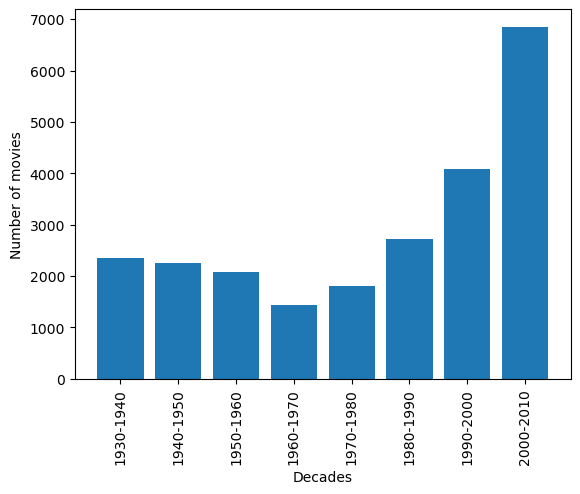

In [21]:
#Import dataframe
df = pd.read_csv('df_movie_usa.csv')

#List of string
years = ['1930','1940','1950','1960','1970','1980','1990','2000','2010']
decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010']

#Initialisation of the decade dictionnary
dic_movie_decades = dict.fromkeys(decades)
for ctr in range(len(years)-1):
    decade_str = years[ctr]+'-'+years[ctr+1]
    dic_movie_decades[decade_str] = {'dataframe' : df[ (df.Movie_date > years[ctr]) & (df.Movie_date < years[ctr+1])] ,
                                   'occurences': len(df[ (df.Movie_date > years[ctr]) & (df.Movie_date < years[ctr+1])] )}

#Plot of the number of movie
data = [dic_movie_decades[decade]['occurences'] for decade in decades]
plt.bar( x=range(len(decades)) , height=data , tick_label=decades) 
plt.xticks( rotation=90 )
plt.xlabel('Decades')
plt.ylabel('Number of movies')
plt.show()

#### Number of movies by genre and decade

In [22]:
import pandas as pd
print(pd.__version__)

1.5.1


In [56]:
df2 = df_movie_usa
df = df2['Movie_genres'].str.replace("'","")
df

0        [Thriller, Science Fiction, Horror, Adventure,...
1         [Mystery, Biographical film, Drama, Crime Drama]
2        [Short Film, Silent film, Indie, Black-and-whi...
3                       [Musical, Comedy, Black-and-white]
4                                 [Drama, Black-and-white]
                               ...                        
29758                          [Thriller, B-movie, Horror]
29759                          [Parody, Americana, Comedy]
29760    [Thriller, Erotic thriller, Psychological thri...
29761                 [Comedy film, Romance Film, Musical]
29762                                     [Satire, Comedy]
Name: Movie_genres, Length: 29763, dtype: object

In [24]:
#Import dataset
df1 = df_movie_usa.copy()

#Add a column decade to assign each movie to a decade
decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010']
decades_code = range(len(decades))
df1['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df1[ (df1['Movie_date']>decade[0:3]) & (df1['Movie_date']<decade[5:8])].index
    df1.loc[index1,'Decade'] = decades_code[ctr]

#Create a dataframe for genre and a dataframe for decade  
df_genre_explode = pd.DataFrame(df1['Movie_genres'].explode())
df_decade = pd.DataFrame(df1['Decade'])

#Main genres
main_genres = df_genre_explode['Movie_genres'].value_counts()
main_genres = main_genres[main_genres>2000] #We assume main genre when the total number of movies is higher than 2000

#Merge genre and decade dataframes
df = pd.merge(df_genre_explode, df_decade, left_index=True, right_index=True)
#Filter with main genres
df = df[df.Movie_genres.isin(main_genres.index)]
#Create a crosstab dataframe
df3 = pd.crosstab(df['Movie_genres'],df['Decade'])
#Plot heatmap
sns.heatmap( df3, annot=True , fmt='.4g'  , xticklabels=decades )
plt.show()


ValueError: zero-size array to reduction operation fmin which has no identity

#### Age of men and women in movies by decade

In [ ]:
#Import dataframes
df1 = pd.read_csv('df_movie_usa.csv')
df2 = pd.read_csv('df_character_usa.csv')

#Create a list of decades and a code for each decade
decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010']
decades_code = range(len(decades))

#Add a decade column and assign a decade code according to the movie date
df1['Decade'],df2['Decade'] = 0,0
for ctr,decade in enumerate(decades):
    index1 = df1[ (df1['Movie_date']>decade[0:3]) & (df1['Movie_date']<decade[5:8])].index
    df1.loc[index1,'Decade']= decades_code[ctr]
    index2 = df2[ (df2['Movie_date']>decade[0:3]) & (df2['Movie_date']<decade[5:8])].index
    df2.loc[index2,'Decade']= decades_code[ctr]






In [ ]:
#Import dataset
df=pd.read_csv('df_character_usa.csv')

#Plot of the actor age across the decades
sns.lineplot(data = df, x='Decade', y='Actor_age_at_movie_release', estimator='mean', hue='Actor_gender' , err_style='bars')
plt.xticks(ticks = decades_code,labels = decades,rotation=90)
plt.show()

#### Part of women in movies by decade

In [ ]:
#Import dataset
df1 = pd.read_csv('df_movie_usa.csv')
df2 = pd.read_csv('df_character_usa.csv')

#Create a dataframe from df_movie_usa and adding a percentage of women column
men_by_movie = df2[df2['Actor_gender']=='M'].groupby('Freebase_movie_ID')['Actor_gender'].agg('count')
women_by_movie = df2[df2['Actor_gender']=='F'].groupby('Freebase_movie_ID')['Actor_gender'].agg('count')
percentage_women_by_movie =  pd.Series((women_by_movie/(men_by_movie+women_by_movie))*100,name='Percentage_of_women')
df_movie_percentage_women = df1.merge(percentage_women_by_movie, on='Freebase_movie_ID')



#Plot
#sns.violinplot(data=df1, x='Decade', y='Percentage_of_women')
sns.violinplot(data=df_movie_percentage_women, x='Decade', y='Percentage_of_women')
plt.xticks(ticks=decades_code,labels=decades,rotation=90)
plt.show()

#### Create a dataframe with age of men and women for each movie

In [ ]:
#Import dataset
df1 = df_movie_percentage_women
df2 = df_character_usa

#Separate the df_character_usa into two dataset: one for women, one for men
df_m = df2[df2.Actor_gender=='M']
df_w = df2[df2.Actor_gender=='F']

#Compute the mean age of men and women for each movie
mean_age_m = pd.Series(df_m.groupby('Freebase_movie_ID')['Actor_age_at_movie_release'].agg('mean'), name='Mean_age_m')
df1 = pd.merge(df1,mean_age_m,on='Freebase_movie_ID')
mean_age_w = pd.Series(df_w.groupby('Freebase_movie_ID')['Actor_age_at_movie_release'].agg('mean'), name='Mean_age_w')
df1 = pd.merge(df1,mean_age_w,on='Freebase_movie_ID')

#Create a list of decades and a code for each decade
decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010']
decades_code = range(len(decades))

#Add a decade column
df1['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df1[ (df1['Movie_date']>decade[0:3]) & (df1['Movie_date']<decade[5:8])].index
    df1.loc[index1,'Decade']= decades_code[ctr]

#Create a new df_movie_usa dataframe adding a mean age column for men and women (for each movie)
df_mean_age=df1





#### Linear regression: what influences the percentage of women?

In [ ]:
#Import the dataset
df = df_mean_age.copy()

#Normalize parameters for the linear regression
df['Movie_revenue'] =  (df['Movie_revenue'] - df['Movie_revenue'].mean())/df['Movie_revenue'].std()
df['Percentage_of_women'] =  (df['Percentage_of_women'] - df['Percentage_of_women'].mean())/df['Percentage_of_women'].std()
df['Mean_age_w'] =  (df['Mean_age_w'] - df['Mean_age_w'].mean())/df['Mean_age_w'].std()




#Create a dataframe that collects the data (coefficient of parameters, p-value) from each linear regression
df_res = pd.DataFrame()
for ctr,decade in enumerate(decades):
    df_temp = df[df.Decade==ctr]
     
    mod = smf.ols(formula = 'Percentage_of_women ~  Movie_revenue+ Mean_age_w ',
              data = df_temp)
    res = mod.fit()
    
    df_res_temp = pd.DataFrame(pd.Series(res.params,name = 'coefficient'))
    df_res_temp['p-value'] = pd.Series(res.pvalues,name='p-value')
    df_res_temp['decade'] = ctr
    
    df_res = pd.concat([df_res,df_res_temp])

#Add a 'significant' column to the linear regression dataframe (df_res). True is assigned if p-value<0.05, False otherwise.
df_res['significant'] = np.where(df_res['p-value'] < 0.05, True, False)    
df_res

In [ ]:
#Barplot of the linear regression coefficients of each decade
fig, ax = plt.subplots(3,3,figsize= (10,8))

for ctr,decade in enumerate(decades):
    df = df_res[df_res.decade==ctr]
    sbplt = ax[math.floor(ctr/3),ctr%3]
    sns.barplot(data = df , x = df.index , y='coefficient', hue='significant' , ax=sbplt , dodge =False )
    sbplt.set_title(decade)
    sbplt.set_xticklabels(labels=['Intercept','Mean_revenue', 'Mean_age_w'], fontsize=7)
    sbplt.set_ylim([-0.5, 0.4])
    
fig.tight_layout()



### 3.2) Lexical data processing

From each summary, we extract the number of occurences of each character (see Part1). Thus, we assume that the principal character is the most quoted in the plot summary. For example, this is the analysis of Avatar summary:

<img src="img/principal_character.png" width=300 height=100 />


Thus, for each movies with a summary, a principal and secondary character are identified. Then, we want to know if the principal character is a man or a woman. To do that, the summary extracted principal character are compared to the characters of the dataset containing information about characters (see Part1). Then, the movie metadata dataset is enriched with this information. We assigned nan values when the movie does not have a summary.

In [ ]:
df = pd.read_csv('df_movie_usa.csv')

#Interesting subset
df[['Freebase_movie_ID','Movie_name','Movie_date','Principal_summary_character','Principal_character_sex','Secondary_summary_character']].head(10)

We want to analyze if the principal character of a movie is a man or a woman.

In [ ]:
df = pd.read_csv('df_movie_usa.csv')
df_men = df[df['Principal_character_sex']=='M']
df_women = df[df['Principal_character_sex']=='F']

#Print the percentage of women first role in all movies of the dataset
print(len(df_women)/ (len(df_men)+len(df_women)) )

#Further work: plot the percentage of women first role in different decades

#### Lexical field

In each summary plot, we analyze the occurences of specific lexical fields which are considered related to the "male gaze".  
The lexical fields are: feminine, sexist, sexiest, beauty, beautiful, positive_emotion, negative_emotion.
These lexical fields are chosen quickly for the moment but will be further investgated in the future.
Also, the number of words in each summary is extracted.

### 3.3) Google trends

#### Initialize pytrends

##### Load pytrends for Google Trends scraping

In [62]:
#import the libraries                     
pytrend = TrendReq(hl='en-US', retries=10) #define the language for the trends and the number of iterations for each request

##### Get actors list in the USA

In [63]:
#Generate actors list
df_character_usa = pd.read_csv('df_movie_usa.csv') #get the US actors dataframe 
actors_df = df_character_usa["Principal_character_actor"].drop_duplicates().dropna() #remove the duplicated actors and NaN

#Get actors list and index
actors_list = actors_df.tolist() #list
actors_index = actors_df.index #index

#Extract 1800 actors from the dataframe
L = 0 #lower bound
U = 10 #upper bound
actors_list_extract = actors_list[L:U] #list
actors_index_extract = actors_index[L:U] #index

#Visualize
actors_df.head(20)

0     Natasha Henstridge
7          Julie Andrews
13         Tyrese Gibson
19    Billy Bob Thornton
24          Peggy Lipton
26       Patrick Dempsey
33           Ava Gardner
38      Shirley MacLaine
39           Tony Curtis
43       Stephen Collins
45         Thomas Dekker
58           Andy García
64     Christopher Curry
73        Dustin Hoffman
77         Ignatius Juma
82         John Travolta
83    Hayden Christensen
84         Louis Hayward
91        Timothy Hutton
93            Brad Davis
Name: Principal_character_actor, dtype: object

#### Test Google Trends data

##### Read the extracted list and get the interest per state in the USA

In [64]:
#Get the extracted list and index for data check 
list = actors_list_extract
index = actors_index_extract
df1 = pd.DataFrame(index=index)

actors_with_data = []
trends_data = []

for i in list:
    pytrend = TrendReq(hl='en-US', timeout=(15,25)) #define the language for the trends and the number of iterations for each request
    pytrend.build_payload([i], geo='US', timeframe='all') #define the region for the trends and the time period for each request
    # Interest by Region
    data_check = (pytrend.interest_by_region()==0).any().sum() #check if the data is available
    actors_with_data = actors_with_data + ([i] if data_check == 0 else []) #get the actors list
    trends_data = trends_data + ([True] if data_check == 0 else [False]) #get a boolean value to enrich the initial dataframe
    df1['Trends data'] = pd.DataFrame(trends_data, index=index[0:len(trends_data)]) #build a temporary dataframe
    df1.to_csv('./Google Trends/Data trends.csv') #save at each iteration for reliability
    time.sleep(3)

##### Combine the results for all the extracted lists

In [67]:
#Import the US actors dataframe and index
index = actors_index
df1 = pd.read_csv('df_movie_usa.csv')
df1 = df1.iloc[index,:] #remove duplicated and NaN values of actors names

df2 = pd.DataFrame() #initialize dataframe

n = 10 #number of .csv files

for i in np.arange(1,n+1):
    df3 = pd.read_csv('./Google Trends/Data trends backups' + str(i) + '.csv').set_index('Unnamed: 0').dropna() #read each .csv file
    df2 = pd.concat([df2,df3]) #combine the dataframes based on the common index

#Combine the final dataframe 
df_actors_trends = df1.join(df2)
df_actors_trends.head(10)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,...,negative_emotion,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Decade,Principal_character_actor,Trends data
0,0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",...,7.0,396.0,1.0,0.0,Ballard,Williams,F,7,Natasha Henstridge,False
7,7,7,7,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}",...,5.0,1678.0,12.0,7.0,Mary,Banks,F,3,Julie Andrews,True
13,13,13,13,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}",...,9.0,730.0,11.0,4.0,Jody,Yvette,M,7,Tyrese Gibson,True
19,19,19,19,25960460,/m/0b6kc_5,Daddy and Them,2001,NaN,101.0,"{""/m/02h40lc"": ""English Language""}",...,0.0,71.0,0.0,0.0,Claude,Montgomery,M,7,Billy Bob Thornton,True
24,24,24,24,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}",...,3.0,334.0,2.0,2.0,Crowe,NaN,F,5,Peggy Lipton,True
26,26,26,26,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}",...,5.0,672.0,8.0,2.0,Randy,Jenny,M,5,Patrick Dempsey,True
33,33,33,33,7028314,/m/0h10pz,The Little Hut,1957-05-03,3600000.0,90.0,"{""/m/02h40lc"": ""English Language""}",...,0.0,52.0,0.0,0.0,Ashlow,Philip,F,2,Ava Gardner,False
38,38,38,38,5894429,/m/0fc8w8,Closing the Ring,2007-09-14,NaN,117.0,"{""/m/02h40lc"": ""English Language""}",...,4.0,326.0,2.0,0.0,Ethel,Jack,F,7,Shirley MacLaine,True
39,39,39,39,12788657,/m/02x4zpv,The Boston Strangler,1968,17810894.0,116.0,"{""/m/02h40lc"": ""English Language""}",...,0.0,71.0,0.0,0.0,DeSalvo,Bottomly,M,3,Tony Curtis,True
43,43,43,43,2154704,/m/06qv1c,Choke Canyon,1986-05-02,NaN,94.0,"{""/m/02h40lc"": ""English Language""}",...,0.0,74.0,0.0,0.0,Dr.,David,M,5,Stephen Collins,True


##### Count the actors with data

In [68]:
#Get the combined dataframe 
df1 = df_actors_trends.copy()

#Compute the data variables
a = df1['Principal_character_actor'].count()
print('There is a total of ' + str(a) + ' main actors and actresses in the USA.')
b = df1['Trends data'].dropna().count()
print('There is a total of ' + str(b) + ' main actors and actresses in the USA for which Google Trends was checked.')
c = df1['Trends data'].sum()
print('There is a total of ' + str(c) + ' actors and actresses with Google Trends data in the USA.')
d = c/b*100
print('It represents ' + str(d) + ' percent of the actors and actresses playing a main role in US movies.')

There is a total of 3335 main actors and actresses in the USA.
There is a total of 1808 main actors and actresses in the USA for which Google Trends was checked.
There is a total of 781 actors and actresses with Google Trends data in the USA.
It represents 43.19690265486726 percent of the actors and actresses playing a main role in US movies.


#### Compare the interest by states

##### Get an extracted list from the dataframe

In [69]:
df1 = df_actors_trends.copy() #get the combined dataframe 

n = 10 #size of the sublist

#Get an extract of the list of actors from the dataframe
actors_list = df1.loc[df1['Trends data'] == True].iloc[0:n]["Principal_character_actor"].values.tolist()
actors_list

['Julie Andrews',
 'Tyrese Gibson',
 'Billy Bob Thornton',
 'Peggy Lipton',
 'Patrick Dempsey',
 'Shirley MacLaine',
 'Tony Curtis',
 'Stephen Collins',
 'Dustin Hoffman',
 'John Travolta']

##### Initialize with first sublist

In [70]:
#The name of the actors has to be separated into sublists as only 5 keywords can be compared

list = actors_list #get the actors list

n = 0 #init number of actors compared
regiondf = pd.DataFrame() #init results dataframe
step = 5 #number of keywords to compare
threshold = 1 #threshold to decide if a keyword is kept or computed later
list_c = [] #init list of compared actors
list_tc = list #init list of actors to compare
list_nc = [] #init list of actors rejected by the threshold

#initialize with first list

#build list without NaN
list_tmp = list[0:step]
print('List to compare is : ' + str(list_tmp))
#run model for keywords
pytrend.build_payload(list_tmp, geo='US', timeframe='all')
#get interest by US state
df1 = pytrend.interest_by_region()
#minimum value
min_tmp = df1.min() < threshold
not_min_tmp = [not item for item in min_tmp]
#drop columns
regiondf_init = df1[df1.columns[~min_tmp]]
#list compared
list_c = [i for (i, v) in zip(list_tmp, not_min_tmp) if v]
#list to compare
list_tc = list[step:]
#list not compared
list_nc = [i for (i, v) in zip(list_tmp, min_tmp) if v]
#number of actors compared
n = n + sum(not_min_tmp)

print('List compared is : ' + str(list_c))
print('List to compare is : ' + str(list_tc))
print('List not compared is : ' + str(list_nc))
print('Number compared is : ' + str(n))

List to compare is : ['Julie Andrews', 'Tyrese Gibson', 'Billy Bob Thornton', 'Peggy Lipton', 'Patrick Dempsey']
List compared is : ['Julie Andrews', 'Tyrese Gibson', 'Billy Bob Thornton', 'Peggy Lipton', 'Patrick Dempsey']
List to compare is : ['Shirley MacLaine', 'Tony Curtis', 'Stephen Collins', 'Dustin Hoffman', 'John Travolta']
List not compared is : []
Number compared is : 5


##### Compute with the rest of the sublists

In [71]:
#Initialize the next iterations
it = 0 #init number of loops

list_init = [list_c[-1]]
list = actors_list

while n < len(list):
    
    it = it + 1
    print("Iteration is : " + str(it))

    for i in range (1, math.ceil(len(list) / (step-1)), 1):
        #build list without NaN
        list_tmp = list_init + list_tc[0:step-1]
        print('List to compare is : ' + str(list_tmp))
        #run model for keywords
        pytrend.build_payload(list_tmp, geo='US', timeframe='all')
        #get interest by US state
        regiondf = pytrend.interest_by_region()
        print(regiondf.head(51))
        #minimum value
        min_tmp = (regiondf.min() < threshold)
        print("Min tmp is : " + str(min_tmp))
        not_min_tmp = [not item for item in min_tmp]
        #drop columns
        regiondf = regiondf[regiondf.columns[~min_tmp]]
        #list compared 
        list_c = list_c + [i for (i, v) in zip(list_tmp, not_min_tmp) if v][1:]
        print('List compared is : ' + str(list_c))
        #list to compare
        list_tc = list[step+i*step-1:]
        print('List to compare is : ' + str(list_tc))
        #list not compared
        list_nc = list_nc + [i for (i, v) in zip(list_tmp, min_tmp) if v]
        print('List not compared is : ' + str(list_nc))
        #number of actors compared
        n = n + sum(not_min_tmp) - 1
        print('Number compared is : ' + str(n))
    
        if regiondf.iloc[:,0].min() >= threshold: #check if the value is high enough compared to the threshold
            #get the mean values
            regiondf_init['Ratio'] = (regiondf_init.iloc[:,-1]/regiondf.iloc[:, 0])
            #put on the same scale
            regiondf = regiondf.multiply(regiondf_init['Ratio'], axis="index")
            #remove ratio column
            regiondf_init = regiondf_init.drop(columns=['Ratio'])
            #combine the actors lists
            regiondf_init = regiondf_init.join(regiondf.iloc[:,1:])
        
        list_init = [list_c[-1]]
    
    #Normalize all the values together as percentages
    regiondf_init['Sum'] = regiondf_init.sum(1)
    regiondf_normalized_check = regiondf_init.divide(regiondf_init['Sum'].max()).multiply(100)
    regiondf_normalized = regiondf_normalized_check.iloc[:, :-1]
    regiondf_normalized
    
    df1 = regiondf_normalized.copy()
    df1 = df1[df1.columns[~(df1.mean() == df1.mean().min())]].join(df1[df1.columns[df1.mean() == df1.mean().min()]])
    list_init = [df1.iloc[:,-1].name]
    list_tc = list_nc
    list_nc = []
    
    print(list_init)
    print(list_nc)
          
#Visualize
regiondf_normalized.head()

regiondf_normalized.to_csv('./Google Trends/df_actors_normalized_2.csv')

Iteration is : 1
List to compare is : ['Patrick Dempsey', 'Shirley MacLaine', 'Tony Curtis', 'Stephen Collins', 'Dustin Hoffman']
                      Patrick Dempsey  Shirley MacLaine  Tony Curtis  \
geoName                                                                
Alabama                            41                16           11   
Alaska                             33                19           11   
Arizona                            39                17           13   
Arkansas                           40                16           15   
California                         35                16           13   
Colorado                           36                15           11   
Connecticut                        37                15           11   
Delaware                           38                17           12   
District of Columbia               34                15           13   
Florida                            39                17           12   
Georgi

In [72]:
#Get the dataframe from Google Trends
regiondf_normalized = pd.read_csv('./Google Trends/df_actors_normalized.csv').set_index('geoName')
regiondf_normalized.head(51)

,Julie Andrews,Tyrese Gibson,Billy Bob Thornton,Peggy Lipton,Patrick Dempsey,Shirley MacLaine,Tony Curtis,Stephen Collins,Dustin Hoffman,John Travolta
geoName,,,,,,,,,,
Alabama,9.005741,6.844363,8.285281,1.801148,10.086429,3.690157,2.952126,2.214094,5.658241,32.063365
Alaska,13.328496,3.602296,7.564822,2.161378,9.365970,5.392528,3.121990,1.986721,8.514518,36.298736
Arizona,11.887578,4.322755,6.484133,2.521607,10.806889,4.834661,3.697093,1.990743,7.109795,40.288839
Arkansas,9.005741,4.322755,12.247807,1.440918,9.005741,3.602296,3.377153,1.576005,4.953157,26.004076
California,11.887578,5.043215,6.123904,2.881837,10.086429,5.043215,3.856576,2.076618,8.603131,34.412524
Colorado,13.328496,3.242067,6.844363,2.161378,10.446659,4.352775,3.192035,3.772405,7.254624,38.086778
Connecticut,11.887578,3.962526,5.403444,3.242067,11.527348,4.673249,3.427049,2.492400,9.034948,33.988615
Delaware,11.527348,5.403444,6.484133,2.521607,10.086429,4.396649,3.103517,1.810385,6.465660,27.564129
District of Columbia,11.167118,5.763674,5.403444,2.881837,10.806889,4.767745,4.132046,3.496346,8.581941,28.730846


##### Validation of the data

In [73]:
#Number of states represented
print('The number of represented states is ' + str(len(regiondf_normalized)) + '.')

The number of represented states is 51.


##### Visualization 01

<AxesSubplot:xlabel='States of the USA', ylabel='Relative number of request since 2004 in each state'>

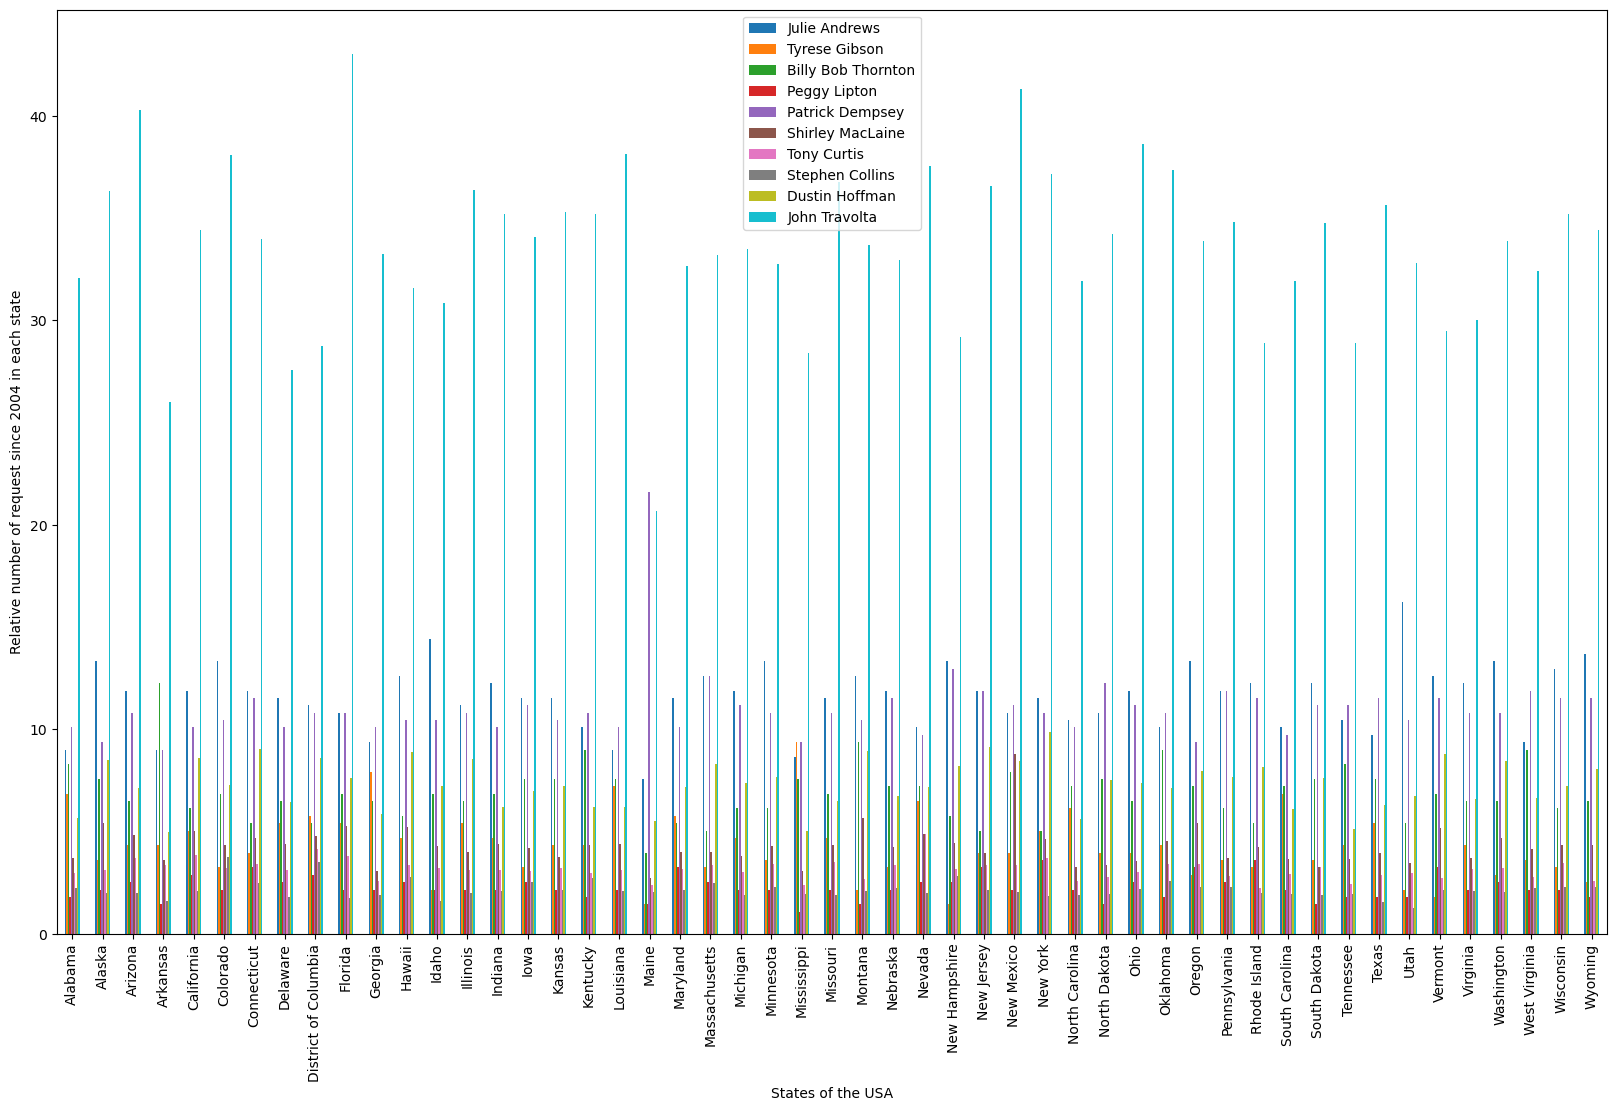

In [74]:
#Visualize the distribution in the states
regiondf_normalized.plot(figsize=(20, 12), kind ='bar', xlabel='States of the USA', ylabel='Relative number of request since 2004 in each state')

<AxesSubplot:xlabel='New York', ylabel='Relative number of request since 2004 in New York'>

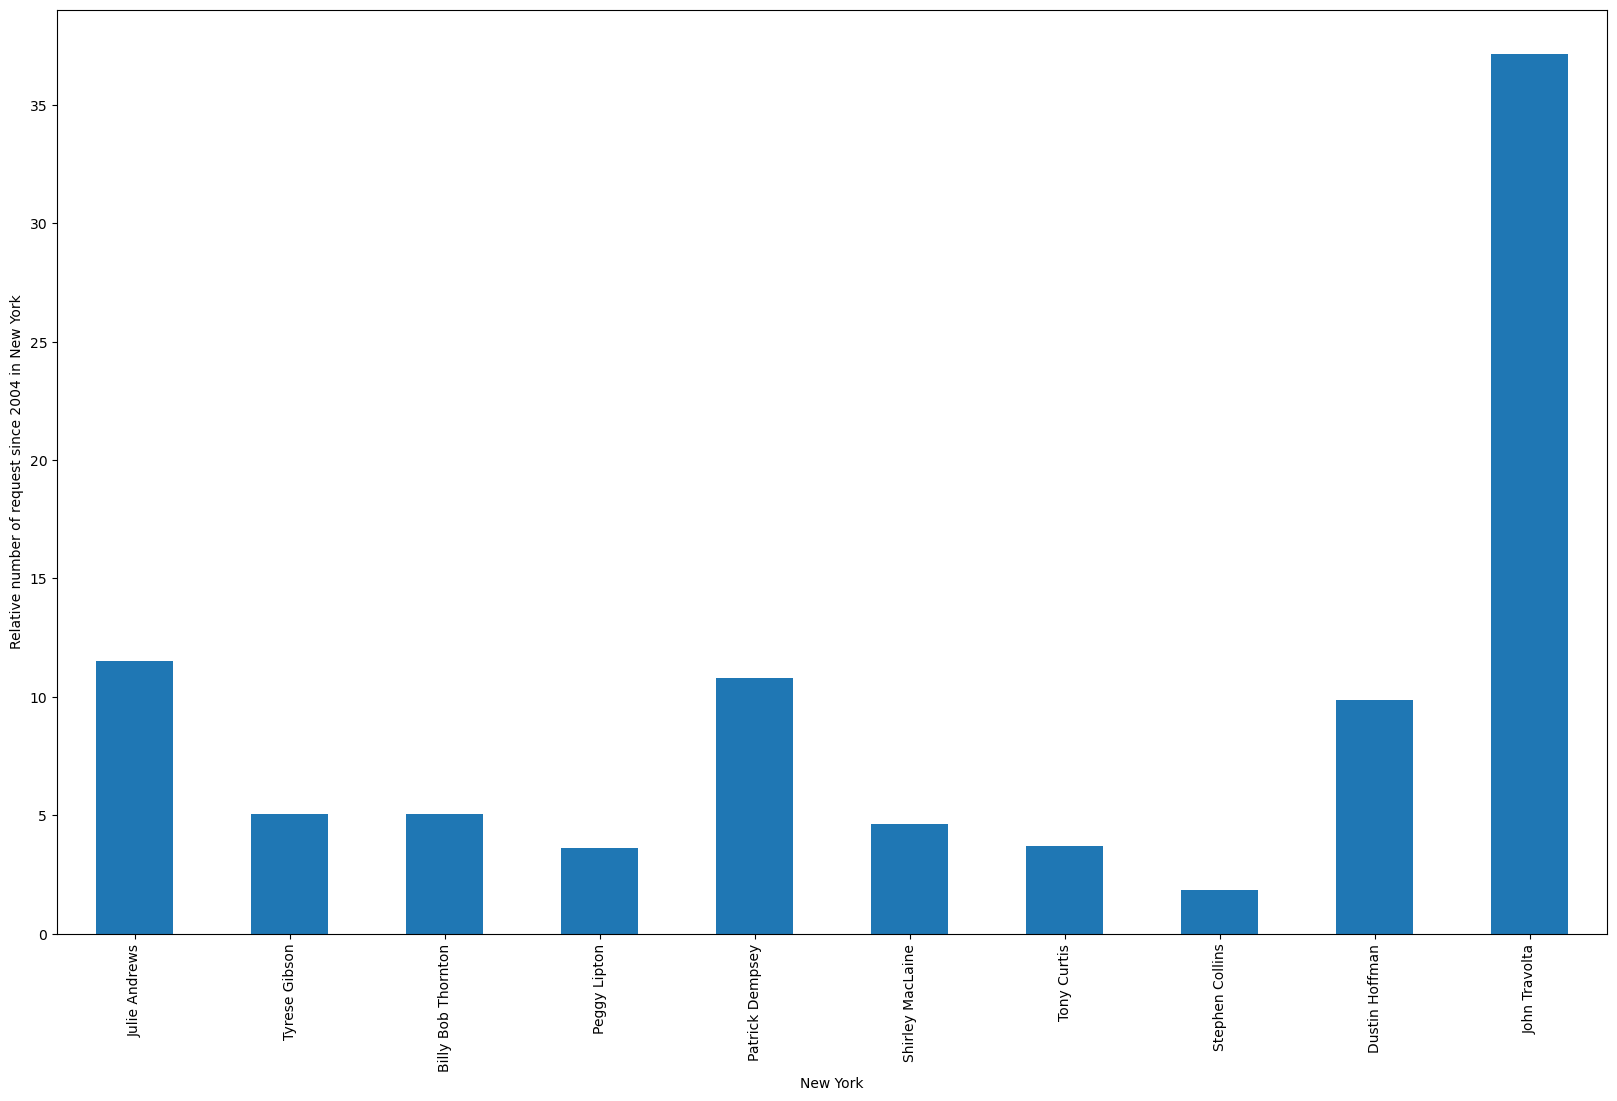

In [37]:
#Visualize the distribution in a specific state
state = "New York" #define the state
ylabel = "Relative number of request since 2004 in " + state

regiondf_normalized.loc[state].plot(figsize=(20, 12), kind ='bar', xlabel=state, ylabel=ylabel)

##### Visualization 02

In [75]:
df1 = regiondf_normalized.copy() #get a copy of the dataframe

#Data used to link the states names to their reference
data_states = {'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'}
 
#Mapping of the dataframe
df1["States_ref"] = df1.index.map(data_states)
df1.head(20)

,Julie Andrews,Tyrese Gibson,Billy Bob Thornton,Peggy Lipton,Patrick Dempsey,Shirley MacLaine,Tony Curtis,Stephen Collins,Dustin Hoffman,John Travolta,States_ref
geoName,,,,,,,,,,,
Alabama,9.005741,6.844363,8.285281,1.801148,10.086429,3.690157,2.952126,2.214094,5.658241,32.063365,AL
Alaska,13.328496,3.602296,7.564822,2.161378,9.365970,5.392528,3.121990,1.986721,8.514518,36.298736,AK
Arizona,11.887578,4.322755,6.484133,2.521607,10.806889,4.834661,3.697093,1.990743,7.109795,40.288839,AZ
Arkansas,9.005741,4.322755,12.247807,1.440918,9.005741,3.602296,3.377153,1.576005,4.953157,26.004076,AR
California,11.887578,5.043215,6.123904,2.881837,10.086429,5.043215,3.856576,2.076618,8.603131,34.412524,CA
Colorado,13.328496,3.242067,6.844363,2.161378,10.446659,4.352775,3.192035,3.772405,7.254624,38.086778,CO
Connecticut,11.887578,3.962526,5.403444,3.242067,11.527348,4.673249,3.427049,2.492400,9.034948,33.988615,CT
Delaware,11.527348,5.403444,6.484133,2.521607,10.086429,4.396649,3.103517,1.810385,6.465660,27.564129,DE
District of Columbia,11.167118,5.763674,5.403444,2.881837,10.806889,4.767745,4.132046,3.496346,8.581941,28.730846,DC


In [77]:
#Compute the most requested actor on Google Trends per state

index = df1.shape[1]-2
df1['Most_famous'] = df1.iloc[:,0:index].idxmax(axis=1) #get the actor that is the most requested on Google
regiondf_normalized_max = df1

regiondf_normalized_max.head(20)

,Julie Andrews,Tyrese Gibson,Billy Bob Thornton,Peggy Lipton,Patrick Dempsey,Shirley MacLaine,Tony Curtis,Stephen Collins,Dustin Hoffman,John Travolta,States_ref,Most_famous
geoName,,,,,,,,,,,,
Alabama,9.005741,6.844363,8.285281,1.801148,10.086429,3.690157,2.952126,2.214094,5.658241,32.063365,AL,John Travolta
Alaska,13.328496,3.602296,7.564822,2.161378,9.365970,5.392528,3.121990,1.986721,8.514518,36.298736,AK,John Travolta
Arizona,11.887578,4.322755,6.484133,2.521607,10.806889,4.834661,3.697093,1.990743,7.109795,40.288839,AZ,John Travolta
Arkansas,9.005741,4.322755,12.247807,1.440918,9.005741,3.602296,3.377153,1.576005,4.953157,26.004076,AR,John Travolta
California,11.887578,5.043215,6.123904,2.881837,10.086429,5.043215,3.856576,2.076618,8.603131,34.412524,CA,John Travolta
Colorado,13.328496,3.242067,6.844363,2.161378,10.446659,4.352775,3.192035,3.772405,7.254624,38.086778,CO,John Travolta
Connecticut,11.887578,3.962526,5.403444,3.242067,11.527348,4.673249,3.427049,2.492400,9.034948,33.988615,CT,John Travolta
Delaware,11.527348,5.403444,6.484133,2.521607,10.086429,4.396649,3.103517,1.810385,6.465660,27.564129,DE,John Travolta
District of Columbia,11.167118,5.763674,5.403444,2.881837,10.806889,4.767745,4.132046,3.496346,8.581941,28.730846,DC,John Travolta


##### Relative requests for John Travolta

In [78]:
fig = px.choropleth(regiondf_normalized_max,
                    locations='States_ref', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='John Travolta',
                    color_continuous_scale="Viridis_r", 
                    title='Relative requests for John Travolta in the US states since 2004'
                    )
fig.show()

##### Most requested actor

In [79]:
fig = px.choropleth(regiondf_normalized_max,
                    locations='States_ref', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Most_famous',
                    color_continuous_scale="Viridis_r", 
                    title='Most requested actors in the US states since 2004'
                    )
fig.show()

#### Get the most related queries

In [80]:
#Define the search terms
list=['actor', 'actress']
pytrend.build_payload(kw_list=list, geo='US', timeframe='all')
#Get related queries
related_queries = pytrend.related_queries()
related_queries_df = pd.DataFrame(related_queries.values())
query_actor_df = related_queries_df.iloc[0,0].rename({'query':'query_actor','value':'score_actor'}, axis='columns') #get the top queries since 2004 for 'actor'
query_actress_df = related_queries_df.iloc[1,0].rename({'query':'query_actress','value':'score_actress'}, axis='columns') #get the top queries since 2004 for 'actress'

In [81]:
#Merge the dataframes
query_df = query_actor_df.join(query_actress_df)
query_df

,query_actor,score_actor,query_actress,score_actress
0,voice actor,100,best actress,100
1,actors,25,black actress,66
2,best actor,21,hot actress,60
3,actor died,10,actresses,45
4,it actor,9,indian actress,43
5,actor dies,8,famous actress,31
6,harry potter actor,7,bollywood actress,26
7,batman actor,5,sexy actress,25
8,character actor,5,tamil actress,22
9,best actor oscar,4,best actress oscar,18


In [82]:
#Isolate the linked words
df1 = query_df.copy()
df1['query_actor'] = df1['query_actor'].__add__(' ').str.replace('actor ','')
df1['query_actress'] = df1['query_actress'].__add__(' ').str.replace('actress ','')
df1

,query_actor,score_actor,query_actress,score_actress
0,voice,100,best,100
1,actors,25,black,66
2,best,21,hot,60
3,died,10,actresses,45
4,it,9,indian,43
5,dies,8,famous,31
6,harry potter,7,bollywood,26
7,batman,5,sexy,25
8,character,5,tamil,22
9,best oscar,4,best oscar,18


In [83]:
data_actor = dict(zip(df1['query_actor'].tolist(), df1['score_actor'].tolist()))
data_actress = dict(zip(df1['query_actress'].tolist(), df1['score_actress'].tolist()))

wc_actor = WordCloud(width=800, height=400, max_words=30, background_color='white').generate_from_frequencies(data_actor)
wc_actress = WordCloud(width=800, height=400, max_words=30, background_color='white').generate_from_frequencies(data_actress)

##### Visualization

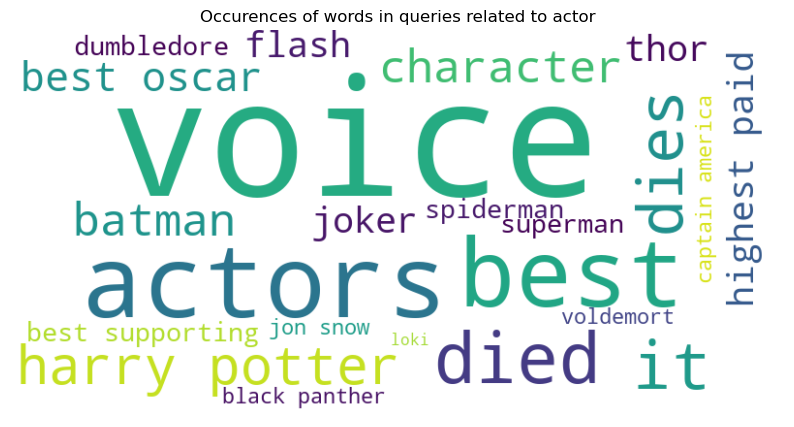

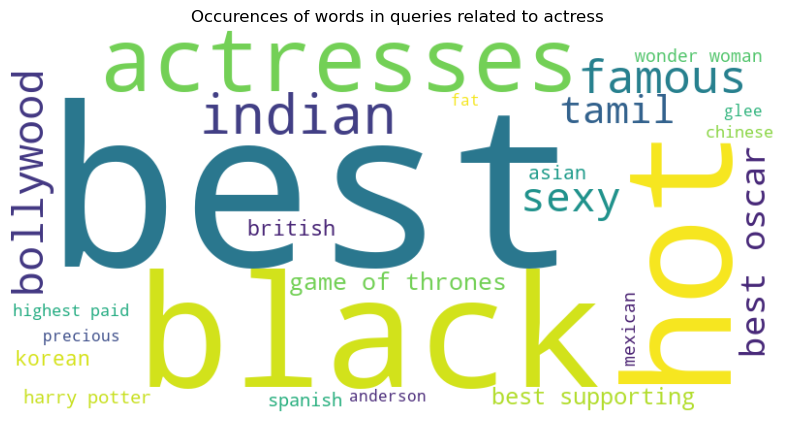

In [84]:
plt.figure(figsize=(10, 10))
plt.imshow(wc_actor, interpolation='bilinear')
plt.axis('off')
plt.title('Occurences of words in queries related to actor')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(wc_actress, interpolation='bilinear')
plt.axis('off')
plt.title('Occurences of words in queries related to actress')
plt.show()